# Minecraft Schematic Loader

This notebook explores loading and visualizing Minecraft schematic files using amulet-core.

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from collections import Counter

# Amulet imports
try:
    from amulet import load_level
    from amulet.api.block import Block
    print("✅ amulet-core imported successfully")
except ImportError as e:
    print(f"❌ Error importing amulet: {e}")
    print("Install with: pip install amulet-core amulet-nbt")

INFO - PyMCTranslate Version 348


✅ amulet-core imported successfully


## 2. Discover Available Schematics

In [2]:
# Path to schematics directory
schematics_dir = Path("../data/schematics")

# Find all schematic files
schematic_files = list(schematics_dir.glob("*.schematic")) + \
                  list(schematics_dir.glob("*.schem")) + \
                  list(schematics_dir.glob("*.litematic"))

print(f"Found {len(schematic_files)} schematic files")
print(f"\nFirst 10 files:")
for i, f in enumerate(schematic_files[:10]):
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"  {i+1}. {f.name} ({size_mb:.2f} MB)")

Found 10665 schematic files

First 10 files:
  1. 10234.schematic (0.00 MB)
  2. 7704.schematic (0.03 MB)
  3. 9719.schematic (0.02 MB)
  4. 9233.schematic (0.00 MB)
  5. 5701.schematic (0.07 MB)
  6. 9005.schematic (0.01 MB)
  7. 12836.schematic (0.01 MB)
  8. 10528.schematic (0.00 MB)
  9. 7532.schematic (0.03 MB)
  10. 10002.schematic (0.00 MB)


## 3. Load a Test Schematic

In [3]:
# Select first schematic for testing
if schematic_files:
    test_schematic = schematic_files[0]
    print(f"Loading: {test_schematic.name}")
    
    # Load with amulet
    try:
        level = load_level(str(test_schematic))
        print("✅ Schematic loaded successfully")
        
        # Get available dimensions
        dimensions = level.dimensions
        print(f"\nAvailable dimensions: {dimensions}")
        
        # Use first dimension (usually 'minecraft:overworld' or empty string)
        dimension = dimensions[0]
        print(f"Using dimension: {dimension}")
        
    except Exception as e:
        print(f"❌ Error loading schematic: {e}")
        level = None
else:
    print("❌ No schematic files found")
    level = None

INFO - Loading level ../data/schematics/10234.schematic


Loading: 10234.schematic
✅ Schematic loaded successfully

Available dimensions: ('main',)
Using dimension: main


## 4. Extract Dimensions and Bounds

In [4]:
if level:
    # Get bounds
    bounds = level.bounds(dimension)
    
    print(f"Bounds:")
    print(f"  X: {bounds.min_x} to {bounds.max_x} (size: {bounds.max_x - bounds.min_x})")
    print(f"  Y: {bounds.min_y} to {bounds.max_y} (size: {bounds.max_y - bounds.min_y})")
    print(f"  Z: {bounds.min_z} to {bounds.max_z} (size: {bounds.max_z - bounds.min_z})")
    
    total_blocks = (bounds.max_x - bounds.min_x) * \
                   (bounds.max_y - bounds.min_y) * \
                   (bounds.max_z - bounds.min_z)
    print(f"\nTotal blocks: {total_blocks:,}")
    
    # Store dimensions for later
    width = bounds.max_x - bounds.min_x
    height = bounds.max_y - bounds.min_y
    depth = bounds.max_z - bounds.min_z

Bounds:
  X: 0 to 13 (size: 13)
  Y: 0 to 26 (size: 26)
  Z: 0 to 37 (size: 37)

Total blocks: 12,506


## 5. Convert to 3D Numpy Array

In [5]:
if level:
    print("Converting to numpy array...")
    print("This may take a moment for large structures...")
    
    # Initialize 3D array
    voxel_array = np.zeros((width, height, depth), dtype=np.int32)
    
    # Build block palette (map block objects to IDs)
    block_palette = {}  # block_string -> id
    block_palette_reverse = {}  # id -> block_string
    next_id = 0
    
    # Reserve ID 0 for air
    air_block = Block('minecraft', 'air')
    block_palette[str(air_block)] = 0
    block_palette_reverse[0] = str(air_block)
    next_id = 1
    
    # Iterate through all blocks
    for x in range(bounds.min_x, bounds.max_x):
        for y in range(bounds.min_y, bounds.max_y):
            for z in range(bounds.min_z, bounds.max_z):
                # Get block at position (using universal block format)
                block = level.get_block(x, y, z, dimension)
                
                # Convert block to string representation
                block_str = str(block)
                
                # Get or create block ID
                if block_str not in block_palette:
                    block_palette[block_str] = next_id
                    block_palette_reverse[next_id] = block_str
                    next_id += 1
                
                block_id = block_palette[block_str]
                
                # Store in array
                array_x = x - bounds.min_x
                array_y = y - bounds.min_y
                array_z = z - bounds.min_z
                voxel_array[array_x, array_y, array_z] = block_id
    
    print(f"✅ Conversion complete")
    print(f"\nArray shape: {voxel_array.shape}")
    print(f"Array dtype: {voxel_array.dtype}")
    print(f"Memory usage: {voxel_array.nbytes / (1024**2):.2f} MB")
    print(f"\nUnique blocks: {len(block_palette)}")

Converting to numpy array...
This may take a moment for large structures...
✅ Conversion complete

Array shape: (13, 26, 37)
Array dtype: int32
Memory usage: 0.05 MB

Unique blocks: 33


## 6. Analyze Block Distribution

In [7]:
if level:
    # Count blocks
    unique, counts = np.unique(voxel_array, return_counts=True)
    
    print("Top 10 most common blocks:\n")
    # Sort by count descending
    sorted_indices = np.argsort(counts)[::-1]
    
    for i in range(min(10, len(unique))):
        idx = sorted_indices[i]
        block_id = unique[idx]
        count = counts[idx]
        percentage = (count / voxel_array.size) * 100
        block_name = block_palette_reverse[block_id]
        print(f"  {i+1}. {block_name}")
        print(f"     Count: {count:,} ({percentage:.1f}%)")
    
    # Calculate air percentage
    air_count = counts[unique == 0][0] if 0 in unique else 0
    air_percentage = (air_count / voxel_array.size) * 100
    print(f"\nAir blocks: {air_count:,} ({air_percentage:.1f}%)")
    print(f"Solid blocks: {voxel_array.size - air_count:,} ({100 - air_percentage:.1f}%)")

Top 10 most common blocks:

  1. universal_minecraft:air
     Count: 9,329 (74.6%)
  2. universal_minecraft:water[falling="false",flowing="false",level="0"]
     Count: 1,726 (13.8%)
  3. universal_minecraft:planks[material="dark_oak"]
     Count: 906 (7.2%)
  4. universal_minecraft:log[axis="z",material="spruce",stripped="false"]
     Count: 134 (1.1%)
  5. universal_minecraft:log[axis="y",material="spruce",stripped="false"]
     Count: 112 (0.9%)
  6. universal_minecraft:wool[color="white"]
     Count: 88 (0.7%)
  7. universal_minecraft:stairs[facing="south",half="bottom",material="dark_oak",shape="straight"]
     Count: 26 (0.2%)
  8. universal_minecraft:fence[east="false",material="dark_oak",north="true",south="true",west="false"]
     Count: 23 (0.2%)
  9. universal_minecraft:log[axis="x",material="spruce",stripped="false"]
     Count: 19 (0.2%)
  10. universal_minecraft:wool[color="black"]
     Count: 19 (0.2%)

Air blocks: 0 (0.0%)
Solid blocks: 12,506 (100.0%)


## 7. Visualize: 2D Slices (Matplotlib)

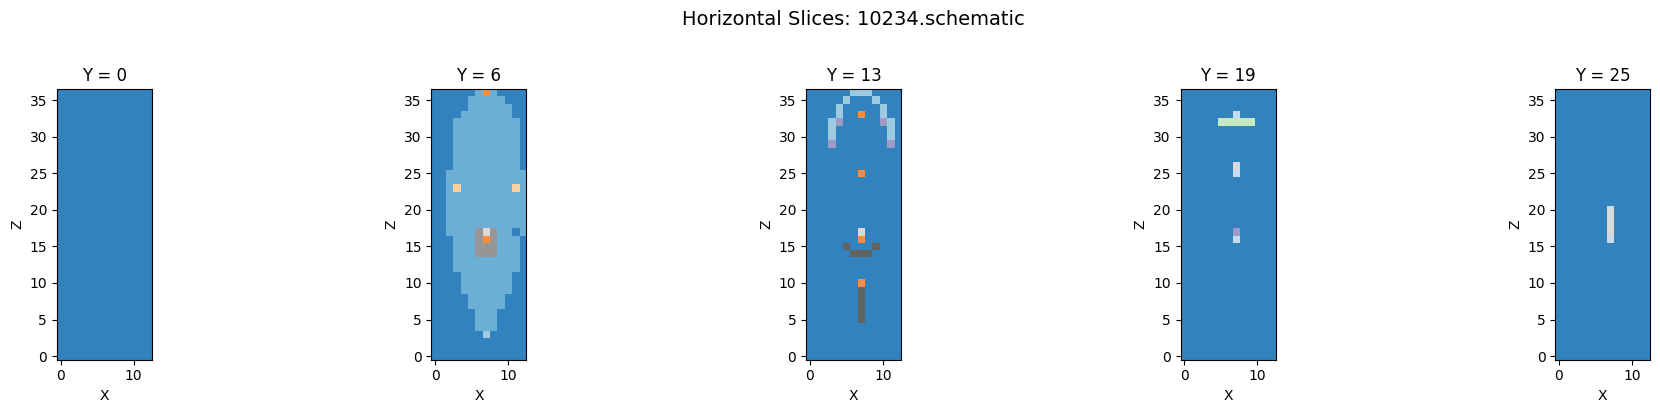

In [8]:
if level:
    # Show horizontal slices at different Y levels
    num_slices = 5
    fig, axes = plt.subplots(1, num_slices, figsize=(20, 4))
    
    for i, ax in enumerate(axes):
        # Select Y level
        y_level = int(height * i / (num_slices - 1)) if num_slices > 1 else height // 2
        y_level = min(y_level, height - 1)
        
        # Get slice (X-Z plane at Y level)
        slice_data = voxel_array[:, y_level, :]
        
        # Plot
        im = ax.imshow(slice_data.T, cmap='tab20c', interpolation='nearest', origin='lower')
        ax.set_title(f'Y = {y_level}')
        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.grid(False)
    
    plt.suptitle(f'Horizontal Slices: {test_schematic.name}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

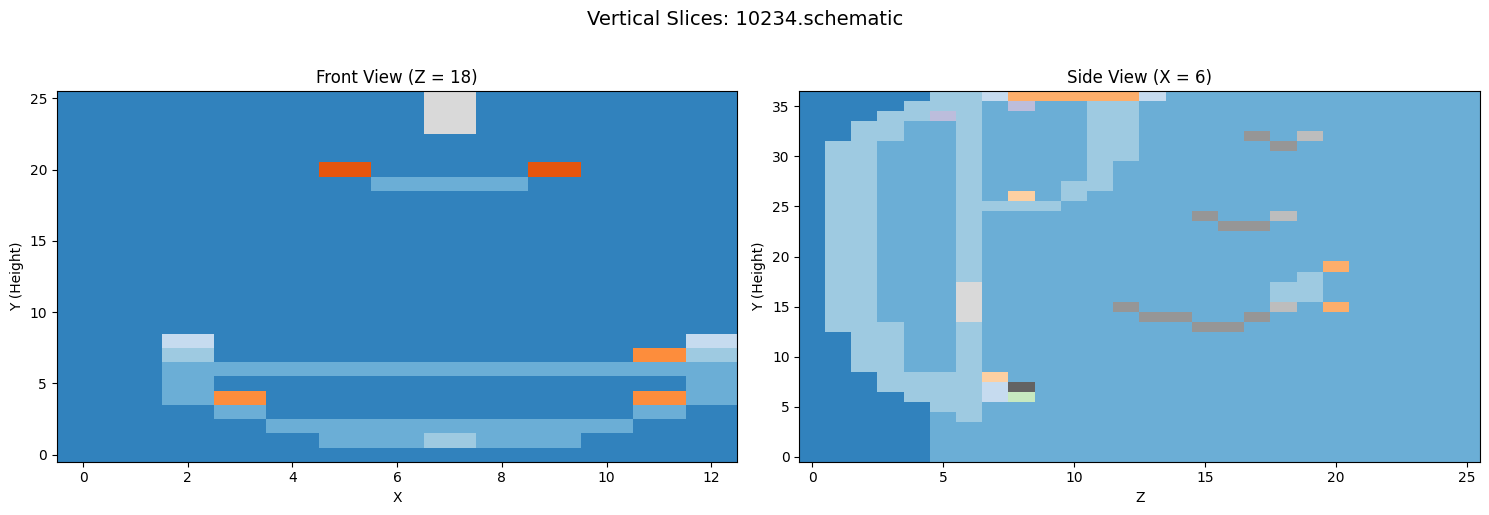

In [9]:
if level:
    # Show vertical slices (side views)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # X-Y plane (front view)
    z_mid = depth // 2
    slice_data = voxel_array[:, :, z_mid]
    axes[0].imshow(slice_data.T, cmap='tab20c', interpolation='nearest', origin='lower', aspect='auto')
    axes[0].set_title(f'Front View (Z = {z_mid})')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y (Height)')
    axes[0].grid(False)
    
    # Y-Z plane (side view)
    x_mid = width // 2
    slice_data = voxel_array[x_mid, :, :]
    axes[1].imshow(slice_data.T, cmap='tab20c', interpolation='nearest', origin='lower', aspect='auto')
    axes[1].set_title(f'Side View (X = {x_mid})')
    axes[1].set_xlabel('Z')
    axes[1].set_ylabel('Y (Height)')
    axes[1].grid(False)
    
    plt.suptitle(f'Vertical Slices: {test_schematic.name}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

## 8. Visualize: 3D Interactive (Plotly)

In [10]:
if level:
    try:
        import plotly.graph_objects as go
        
        # For large structures, we need to downsample
        max_blocks = 10000  # Limit for performance
        
        # Find all air block IDs (any block with 'air' in name)
        air_ids = [block_id for block_id, block_name in block_palette_reverse.items() 
                   if 'air' in block_name.lower()]
        
        # Get non-air blocks (exclude all air variants)
        non_air_mask = ~np.isin(voxel_array, air_ids)
        non_air_count = np.sum(non_air_mask)
        
        print(f"Air block IDs to exclude: {air_ids}")
        print(f"Non-air blocks: {non_air_count:,}")
        
        if non_air_count > max_blocks:
            print(f"⚠️  Too many blocks for visualization ({non_air_count:,} > {max_blocks:,})")
            print(f"Sampling {max_blocks:,} random blocks...")
            
            # Get coordinates of non-air blocks
            x_coords, y_coords, z_coords = np.where(non_air_mask)
            
            # Random sample
            indices = np.random.choice(len(x_coords), max_blocks, replace=False)
            x_coords = x_coords[indices]
            y_coords = y_coords[indices]
            z_coords = z_coords[indices]
        else:
            x_coords, y_coords, z_coords = np.where(non_air_mask)
        
        # Get block IDs for colors
        block_ids = voxel_array[x_coords, y_coords, z_coords]
        
        # Create 3D scatter plot
        fig = go.Figure(data=[go.Scatter3d(
            x=x_coords,
            y=y_coords,
            z=z_coords,
            mode='markers',
            marker=dict(
                size=2,
                color=block_ids,
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Block ID")
            ),
            text=[block_palette_reverse.get(bid, f'Block {bid}') for bid in block_ids],
            hovertemplate='%{text}<br>X: %{x}<br>Y: %{y}<br>Z: %{z}<extra></extra>'
        )])
        
        fig.update_layout(
            title=f'3D View: {test_schematic.name}',
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y (Height)',
                zaxis_title='Z',
                aspectmode='data'
            ),
            width=900,
            height=700
        )
        
        fig.show()
        
    except ImportError:
        print("❌ Plotly not installed. Install with: pip install plotly")

Air block IDs to exclude: [0, 2, 15, 22, 24, 28]
Non-air blocks: 3,147


## 9. Save Processed Data

In [6]:
if level:
    # Save as compressed numpy array
    output_dir = Path("../data/processed_schematics")
    output_dir.mkdir(exist_ok=True)
    
    output_name = test_schematic.stem + "_processed.npz"
    output_path = output_dir / output_name
    
    # Save voxel array and palette
    np.savez_compressed(
        output_path,
        voxels=voxel_array,
        palette=json.dumps(block_palette_reverse),
        shape=voxel_array.shape,
        original_file=str(test_schematic)
    )
    
    saved_size = output_path.stat().st_size / (1024 * 1024)
    original_size = test_schematic.stat().st_size / (1024 * 1024)
    
    print(f"✅ Saved to: {output_path}")
    print(f"\nFile sizes:")
    print(f"  Original: {original_size:.2f} MB")
    print(f"  Processed: {saved_size:.2f} MB")
    print(f"  Ratio: {saved_size/original_size:.2f}x")

✅ Saved to: ../data/processed_schematics/10234_processed.npz

File sizes:
  Original: 0.00 MB
  Processed: 0.00 MB
  Ratio: 1.82x


## 10. Test Loading Saved Data

In [11]:
if level:
    # Load the saved data
    print("Testing load from saved file...")
    
    loaded = np.load(output_path, allow_pickle=True)
    
    loaded_voxels = loaded['voxels']
    loaded_palette = json.loads(str(loaded['palette']))
    loaded_shape = tuple(loaded['shape'])
    
    print(f"✅ Loaded successfully")
    print(f"Shape: {loaded_shape}")
    print(f"Unique blocks: {len(loaded_palette)}")
    print(f"Arrays match: {np.array_equal(loaded_voxels, voxel_array)}")

Testing load from saved file...
✅ Loaded successfully
Shape: (13, 26, 37)
Unique blocks: 33
Arrays match: True


## 11. Batch Process Multiple Schematics

In [ ]:
def load_schematic_to_array(schematic_path):
    """Load a schematic file and convert to numpy array"""
    try:
        level = load_level(str(schematic_path))
        dimension = level.dimensions[0]
        bounds = level.bounds(dimension)
        
        # Get dimensions
        width = bounds.max_x - bounds.min_x
        height = bounds.max_y - bounds.min_y
        depth = bounds.max_z - bounds.min_z
        
        # Initialize array
        voxel_array = np.zeros((width, height, depth), dtype=np.int32)
        
        # Build palette
        block_palette = {}
        block_palette_reverse = {}
        next_id = 0
        
        # Reserve 0 for air
        air_block = Block('minecraft', 'air')
        block_palette[str(air_block)] = 0
        block_palette_reverse[0] = str(air_block)
        next_id = 1
        
        # Extract blocks
        for x in range(bounds.min_x, bounds.max_x):
            for y in range(bounds.min_y, bounds.max_y):
                for z in range(bounds.min_z, bounds.max_z):
                    block = level.get_block(x, y, z, dimension)
                    block_str = str(block)
                    
                    if block_str not in block_palette:
                        block_palette[block_str] = next_id
                        block_palette_reverse[next_id] = block_str
                        next_id += 1
                    
                    block_id = block_palette[block_str]
                    voxel_array[x - bounds.min_x, y - bounds.min_y, z - bounds.min_z] = block_id
        
        return {
            'voxels': voxel_array,
            'palette': block_palette_reverse,
            'shape': voxel_array.shape,
            'success': True,
            'error': None
        }
        
    except Exception as e:
        return {
            'voxels': None,
            'palette': None,
            'shape': None,
            'success': False,
            'error': str(e)
        }

print("✅ Function defined: load_schematic_to_array()")

In [ ]:
# Test on first 5 schematics
num_to_test = min(5, len(schematic_files))

print(f"Testing batch processing on {num_to_test} schematics...\n")

results = []

for i, schematic_path in enumerate(schematic_files[:num_to_test]):
    print(f"[{i+1}/{num_to_test}] Processing: {schematic_path.name}")
    
    result = load_schematic_to_array(schematic_path)
    
    if result['success']:
        shape = result['shape']
        num_blocks = result['voxels'].size
        unique_blocks = len(result['palette'])
        print(f"  ✅ Success: {shape} ({num_blocks:,} blocks, {unique_blocks} types)\n")
    else:
        print(f"  ❌ Failed: {result['error']}\n")
    
    results.append({
        'file': schematic_path.name,
        'success': result['success'],
        'shape': result['shape'],
        'error': result['error']
    })

# Summary
success_count = sum(1 for r in results if r['success'])
print(f"\n{'='*60}")
print(f"Summary: {success_count}/{num_to_test} schematics loaded successfully")
print(f"Success rate: {success_count/num_to_test*100:.1f}%")

## Next Steps

1. ✅ Successfully load schematics with amulet-core
2. ✅ Convert to 3D numpy arrays
3. ✅ Visualize with matplotlib and plotly
4. ✅ Save in compressed format
5. ✅ Test batch processing

**TODO:**
- Create SchematicLoader class in src/
- Add VoxelProcessor for normalization
- Build PyTorch Dataset class
- Implement data augmentation (rotations, flips)
- Create visualization utilities module